# Lesson 2 : LangGraph Components

In [1]:
from dotenv import load_dotenv
_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [5]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [6]:
class Agent:
    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [24]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatGroq(model="llama-3.1-8b-instant")  #reduce inference cost
abot = Agent(model, [tool],memory, system=prompt)

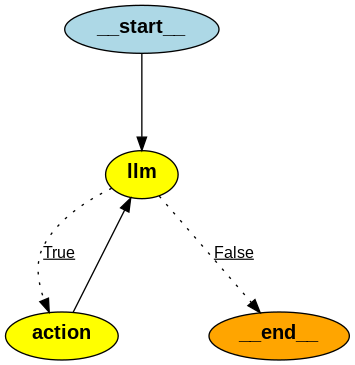

In [12]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [25]:
messages = [HumanMessage(content="What is the weather in sf?")]
# result = abot.graph.invoke({"messages": messages})

In [25]:
result['messages'][-1].content

'The current weather in San Francisco is partly cloudy with a temperature of 13.9 degrees Celsius (57 degrees Fahrenheit). The wind is coming from the southwest at a speed of 4.5 miles per hour (7.2 kilometers per hour). The humidity is at 93%.'

In [24]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zqw2', 'function': {'arguments': '{"query":"weather in sf"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 98, 'prompt_tokens': 1284, 'total_tokens': 1382, 'completion_time': 0.157360117, 'prompt_time': 0.076853328, 'queue_time': 0.0017755849999999962, 'total_time': 0.234213445}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f47bcde8-c8fd-4e90-933a-4535a1af5e36-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in sf'}, 'id': 'call_zqw2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1284, 'output_tokens': 98, 'total_tokens': 1382}),
  ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\':

In [26]:
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v['messages'])

[AIMessage(content='The current weather in San Francisco is still partly cloudy with a temperature of 22.2 degrees Celsius (72.0 degrees Fahrenheit). The wind is coming from the west-southwest at a speed of 3.6 miles per hour (5.8 kilometers per hour). The humidity is at 57% and it is not daytime. This information was obtained from the first URL provided by the tool in our previous conversation.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 2147, 'total_tokens': 2234, 'completion_time': 0.116, 'prompt_time': 0.461242568, 'queue_time': 0.002733727999999991, 'total_time': 0.577242568}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9cb648b966', 'finish_reason': 'stop', 'logprobs': None}, id='run-6f07ba5a-e253-40f1-8110-5d758f926d8c-0', usage_metadata={'input_tokens': 2147, 'output_tokens': 87, 'total_tokens': 2234})]


In [27]:
messages = [HumanMessage(content="What about in la?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='The current weather in Los Angeles is still misty with a temperature of 17.8 degrees Celsius (64.0 degrees Fahrenheit). The wind is coming from the south-southeast at a speed of 4.0 miles per hour (6.5 kilometers per hour). The humidity is at 93% and it is not daytime. This information was obtained from the first URL provided by the tool in our previous conversation.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 2248, 'total_tokens': 2335, 'completion_time': 0.116, 'prompt_time': 0.467402269, 'queue_time': 0.6734482610000001, 'total_time': 0.583402269}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9cb648b966', 'finish_reason': 'stop', 'logprobs': None}, id='run-78cc6da2-8c2c-41e8-90e0-ce92adc89624-0', usage_metadata={'input_tokens': 2248, 'output_tokens': 87, 'total_tokens': 2335})]}


In [28]:
messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='San Francisco is warmer with a current temperature of 22.2 degrees Celsius (72.0 degrees Fahrenheit), compared to Los Angeles with a current temperature of 17.8 degrees Celsius (64.0 degrees Fahrenheit).', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 2349, 'total_tokens': 2394, 'completion_time': 0.06, 'prompt_time': 0.482429749, 'queue_time': 0.0032284320000000033, 'total_time': 0.542429749}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9cb648b966', 'finish_reason': 'stop', 'logprobs': None}, id='run-308926a1-a7ba-4279-925f-6d443c6b154e-0', usage_metadata={'input_tokens': 2349, 'output_tokens': 45, 'total_tokens': 2394})]}


In [48]:
messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_k19b', 'function': {'arguments': '{"query":"which one is warmer, the sun or a stove?"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 105, 'prompt_tokens': 1283, 'total_tokens': 1388, 'completion_time': 0.168536421, 'prompt_time': 0.066607603, 'queue_time': 0.0008861169999999918, 'total_time': 0.235144024}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7a10a391-88ea-45ea-8af7-d55282c12f5f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'which one is warmer, the sun or a stove?'}, 'id': 'call_k19b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1283, 'output_tokens': 105, 'total_tokens': 1388})]}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'which one is warmer, the sun or a stove?'}, 'id': 'ca

In [30]:
from langchain_core.messages import AIMessageChunk, HumanMessage

messages = [HumanMessage(content="What is the weather in SF today now?")]
thread = {"configurable": {"thread_id": "4"}}
async for msg, metadata in abot.graph.astream({"messages": messages}, thread,  stream_mode="messages"):
    if msg.content and not isinstance(msg,HumanMessage):
        print(msg.content, end="|", flush=True)

    if isinstance(msg, AIMessageChunk):
        if first:
            gathered = msg
            first = False
        else:
            gathered = gathered + msg

        if msg.tool_call_chunks:
            print(gathered.tool_calls)



Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'San Francisco weather today now'}, 'id': 'call_z089', 'type': 'tool_call'}
Back to the model!
[{'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.78, 'lon': -122.42, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1727153442, 'localtime': '2024-09-23 21:50'}, 'current': {'last_updated_epoch': 1727153100, 'last_updated': '2024-09-23 21:45', 'temp_c': 22.2, 'temp_f': 72.0, 'is_day': 0, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/night/116.png', 'code': 1003}, 'wind_mph': 3.6, 'wind_kph': 5.8, 'wind_degree': 250, 'wind_dir': 'WSW', 'pressure_mb': 1009.0, 'pressure_in': 29.79, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 57, 'cloud': 25, 'feelslike_c': 24.6, 'feelslike_f': 76.3, 'windchill_c': 15.3, 'windchill_f': 59.5, 'heatindex_c': 15.3, 'heatindex_f': 59.6, 'dewpoin

In [21]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages}, thread)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in SF and LA'}, 'id': 'call_768r', 'type': 'tool_call'}
Back to the model!


In [22]:
result['messages'][-1].content

"The current weather in San Francisco is partly cloudy with a temperature of 22.8 degrees Celsius (73.0 degrees Fahrenheit) as of 21:15 on September 23, 2024. I couldn't find any recent weather information for Los Angeles. However, the weather in San Francisco is currently partly cloudy."

In [ ]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

In [29]:
print(result['messages'][-1].content)

The Kansas City Chiefs won Super Bowl 2024. Their headquarters are located in Missouri. According to the US Bureau of Economic Analysis, Missouri's Gross Domestic Product (GDP) for 2024 was approximately 355.6 billion US dollars.
